In [2]:
# Red Wine Quality Prediction

## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set(style="whitegrid")

In [3]:
# Load the dataset
data = pd.read_csv('/Users/mikaelfahre/Desktop/Programmering/Codecademy Portefølje/Red Wine Quality/winequality-red.csv')

# Display the first few rows of the dataset
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


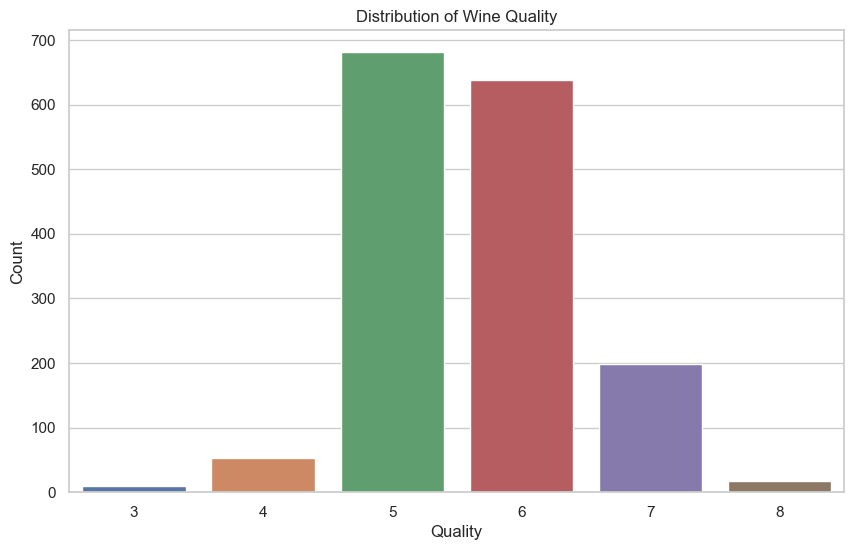

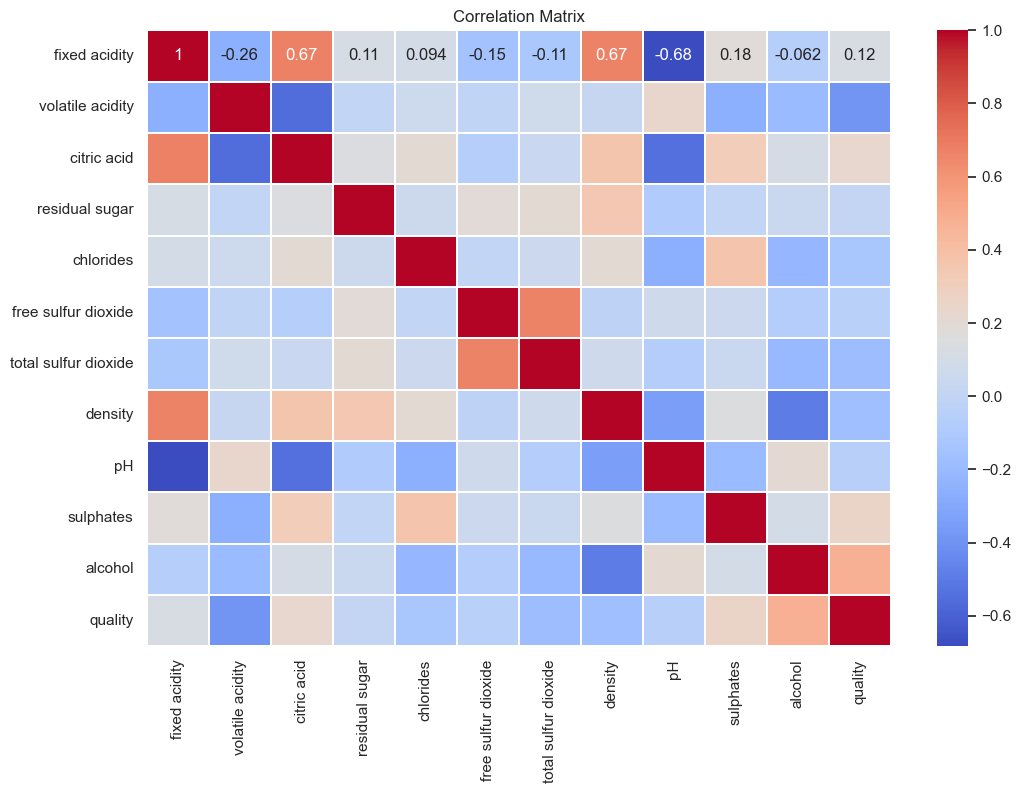

In [4]:
# Summary statistics
data.describe()

# Check for missing values
data.isnull().sum()

# Plot the distribution of wine quality
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=data)
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.2)
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Convert quality into binary classification: good (1) and not good (0)
data['quality'] = data['quality'].apply(lambda x: 1 if x > 6.5 else 0)

# Split the data into features and target variable
X = data.drop('quality', axis=1)
y = data['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [6]:
# Define a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier())
])

# Define parameter grids for different models
param_grid = [
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__penalty': ['l2']
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf']
    }
]

# Define GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Train the models
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_:.2f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'classifier': RandomForestClassifier(n_estimators=50), 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best ROC AUC score: 0.90


              precision    recall  f1-score   support

           0       0.94      0.99      0.97       346
           1       0.92      0.63      0.75        54

    accuracy                           0.94       400
   macro avg       0.93      0.81      0.86       400
weighted avg       0.94      0.94      0.94       400

ROC AUC Score: 0.94


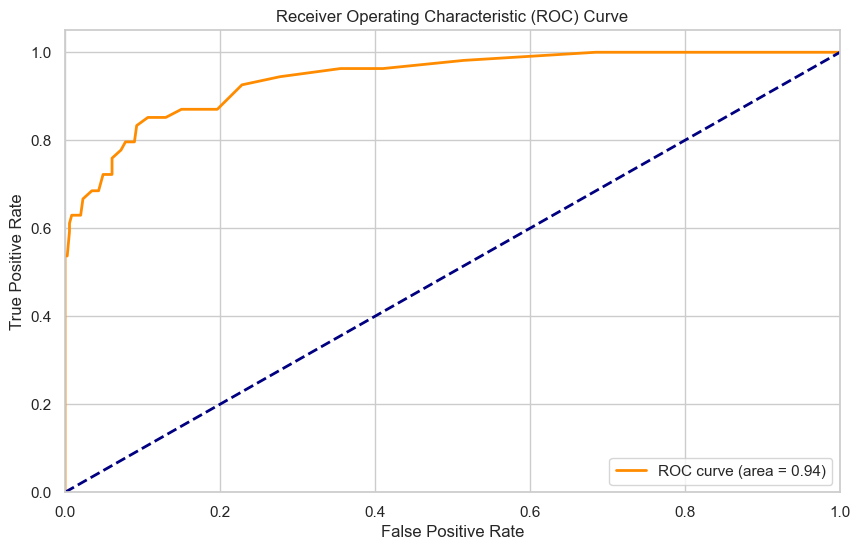

In [7]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()